In [3]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import pylab as pl
import seaborn as sns

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [4]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'MSFT', 'GOOG']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2016, 12, 31)

dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2010-01-06,27.550818,27.660055,27.084312,27.112585,-0.015906,27.434641,27.797058,27.072225,-0.014205,27.062465
2010-01-07,27.212826,27.244955,26.865839,27.062465,-0.001849,27.346481,27.822180,26.870781,-0.016027,27.242385
2010-01-08,27.026481,27.244955,26.867124,27.242385,0.006648,27.294304,27.740322,26.848286,-0.009486,27.242385
2010-01-09,27.026481,27.244955,26.867124,27.242385,0.000000,27.242127,27.622061,26.862194,-0.009486,27.242385
2010-01-10,27.026481,27.244955,26.867124,27.242385,0.000000,27.180441,27.353743,27.007138,-0.011195,27.002063


## Find hyperparameters for model

In [5]:
def cross_val_splits(X, n_splits=5):
    splits = TimeSeriesSplit(n_splits)
    cv_splits = []

    for train_index, test_index in splits.split(X):
        cv_splits.append((train_index, test_index))

    return cv_splits

In [6]:
lasso = Lasso(random_state=rs)
lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

ridge = Ridge(random_state=rs)
ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

elasticnet = ElasticNet(random_state=rs)
elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

lin_reg = LinearRegression()

models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

scores = []
estimators = []

for model, params in models_params:
    class_name = model.__class__.__name__
    
    print ("\n{0}: \n".format(class_name))

    steps = [('scaler', StandardScaler()), ('reg', model)]
    pipe = Pipeline(steps)

    cv_splits = cross_val_splits(data, n_splits = 5)
    grid_search = GridSearchCV(pipe, params, cv = cv_splits)

    grid_search.fit(data, target)

    best_params = grid_search.best_params_
    print('best parameters: {0}'.format(best_params))

    best_score = grid_search.best_score_
    print('best score: {0}'.format(best_score))
    
    scores.append(best_score)

    best_estimator = grid_search.best_estimator_
    estimators.append(best_estimator)


Lasso: 



/Users/ciprian/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'reg__max_iter': 10000, 'reg__alpha': 0.001}
best score: 0.986069473919

Ridge: 

best parameters: {'reg__alpha': 0.1}
best score: 0.986001216635

ElasticNet: 

best parameters: {'reg__l1_ratio': 0.1, 'reg__alpha': 0.001}
best score: 0.985248601666

LinearRegression: 

best parameters: {}
best score: 0.985978374387


## Generate training and testing datasets

In [7]:
data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

print ('Training set has {0} samples.'.format(X_train.shape[0]))
print ('Testing set has {0} samples.'.format(X_test.shape[0]))

Training set has 1785 samples.
Testing set has 766 samples.


In [8]:
def plot_predictions(title, y, y_hat):
    pl.title(title)
    pl.plot(y, y_hat, 'ro')
    pl.plot([np.amin(y), np.amax(y)],[np.amin(y_hat), np.amax(y_hat)], 'g-')
    pl.xlabel('Real values')
    pl.ylabel('Predicted values')
    pl.show()

In [9]:
def print_cross_val_accuracy(est, X, y):
    scores = cross_val_score(est, X, y)
    print('cross validation accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


Lasso: 

score for training set: 0.998687692367
cross validation accuracy: 1.00 (+/- 0.00)
score for test set: 0.99850160467
cross validation accuracy: 1.00 (+/- 0.00)


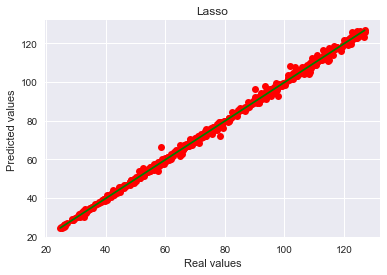


Ridge: 

score for training set: 0.998693180297
cross validation accuracy: 1.00 (+/- 0.00)
score for test set: 0.998511552174
cross validation accuracy: 1.00 (+/- 0.00)


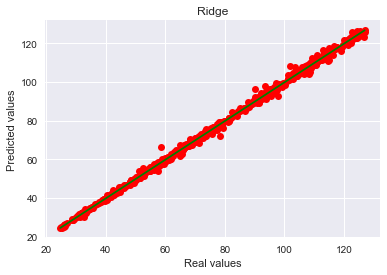


ElasticNet: 

score for training set: 0.99856945475
cross validation accuracy: 1.00 (+/- 0.00)
score for test set: 0.998344297709
cross validation accuracy: 1.00 (+/- 0.00)


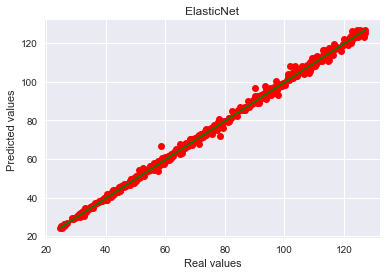


LinearRegression: 

score for training set: 0.99869786253
cross validation accuracy: 1.00 (+/- 0.00)
score for test set: 0.998528337659
cross validation accuracy: 1.00 (+/- 0.00)


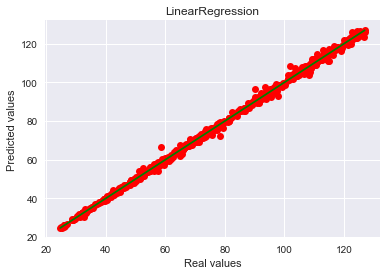

In [10]:
for reg in estimators:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    reg.fit(X_train, y_train)
    
    print('score for training set: {0}'.format(reg.score(X_train, y_train)))
    
    print_cross_val_accuracy(reg, X_train, y_train)

    y_hat_test = reg.predict(X_test)
    print('score for test set: {0}'.format(reg.score(X_test, y_test)))
    
    print_cross_val_accuracy(reg, X_test, y_test)
    
    plot_predictions(class_name, y_test, y_hat_test)

## Generate a validation set and test the prediction accuracy

In [19]:
symbol = tickers[0]
window = 5
look_ahead = 1
valid_start_date = datetime.datetime(2017, 1, 1)
valid_end_date = datetime.datetime(2017, 8, 31)

valid_dataset = su.preprocess_data(symbol, window, look_ahead, valid_start_date, valid_end_date)

valid_dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2017-01-06,115.337596,116.700551,115.031425,116.453639,0.011148,115.128215,116.674912,113.581518,0.015153,116.453639
2017-01-07,115.337596,116.700551,115.031425,116.453639,0.000000,115.475867,117.312787,113.638947,0.015153,116.453639
2017-01-08,115.337596,116.700551,115.031425,116.453639,0.000000,115.823519,117.597684,114.049355,0.015153,117.520300
2017-01-09,116.493145,117.954865,116.483269,117.520300,0.009160,116.410183,118.076566,114.743800,0.025599,117.638817
2017-01-10,117.303017,117.905483,116.838822,117.638817,0.001008,116.904007,118.140234,115.667780,0.021439,118.270913



Lasso: 

score for validation set: 0.985214993103


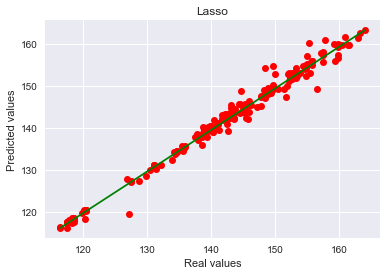


Ridge: 

score for validation set: 0.985160965763


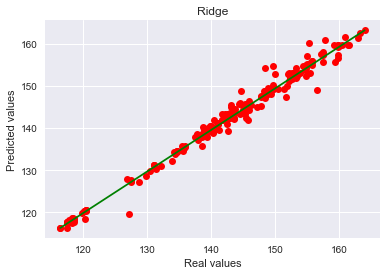


ElasticNet: 

score for validation set: 0.982768143586


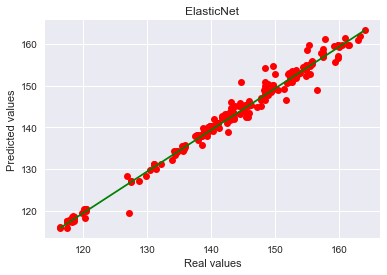


LinearRegression: 

score for validation set: 0.985197506525


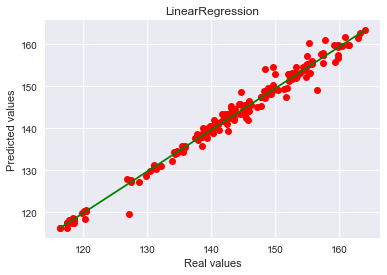


r2 score for average predictions: 0.984810715027

mean squared error for average predictions: 1.9985867625


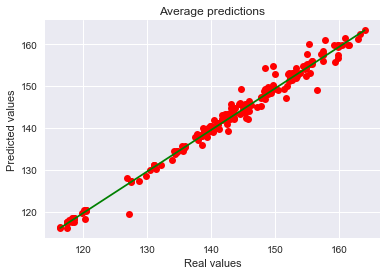

In [20]:
validation_data = valid_dataset.drop(labels=['Future Price'], axis=1)
validation_target = valid_dataset['Future Price']

predictions = []

for reg in estimators:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    validation_pred = reg.predict(validation_data)
    
    score = reg.score(validation_data, validation_target)
    print('score for validation set: {0}'.format(score))
    
    predictions.append(validation_pred)
    plot_predictions(class_name, validation_target, validation_pred)
        
average_predictions = np.zeros(validation_target.shape[0])

for p in predictions:
    average_predictions += p

average_predictions /= len(predictions)
    
print('\nr2 score for average predictions: {0}'.format(r2_score(validation_target, average_predictions)))
print('\nmean squared error for average predictions: {0}'.format(mean_squared_error(validation_target, average_predictions)))

plot_predictions('Average predictions', validation_target, average_predictions)


In [21]:
def up_or_down(x):
    diff = np.roll(x, -1) - x
    ud = [1 if v > 0 else 0 for v in diff]
    return np.array(ud[:-1])

ud_real = up_or_down(validation_target.values)
ud_predicted = up_or_down(average_predictions)

t = np.vstack((ud_real, ud_predicted))
total_predictions = ud_real.shape[0]
correct_predictions = len(np.where(t[0] == t[1])[0])

print('Correct prediction percentage: {0:.2f}'.format((float(correct_predictions) / total_predictions) * 100))

Correct prediction percentage: 46.19


## Identify the market trends using unsupervised learning

In [67]:
rs = 42 # random state
symbol = 'AAPL'
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 8, 31)

all_dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

labels_to_drop = [\
                  'Future Price', \
                  'Daily return', \
                 'Rolling mean {0}'.format(window), \
                 'Lower Bollinger band {0}'.format(window), \
                 'Upper Bollinger band {0}'.format(window), \
                 'Cummulative return {0}'.format(window) \
#                   'Adj. Open', \
#                   'Adj. High', \
#                   'Adj. Low'\
                 ]
dataset = all_dataset.drop(labels=labels_to_drop, axis=1)
target = all_dataset['Future Price']

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close
2010-01-06,27.550818,27.660055,27.084312,27.112585
2010-01-07,27.212826,27.244955,26.865839,27.062465
2010-01-08,27.026481,27.244955,26.867124,27.242385
2010-01-09,27.026481,27.244955,26.867124,27.242385
2010-01-10,27.026481,27.244955,26.867124,27.242385


In [ ]:
'''
mix = GaussianMixture(random_state=rs)
mix_params = {'n_components' : [2, 3, 4, 5, 6], \
              'covariance_type' : ['full', 'tied', 'diag', 'spherical'], \
              'max_iter' : [1000, 10000, 100000]
             }

cv_splits = cross_val_splits(dataset, n_splits = 5)

grid_search = GridSearchCV(mix, mix_params, cv = cv_splits)

grid_search.fit(dataset, target)

best_params = grid_search.best_params_
print('best parameters: {0}'.format(best_params))

regimes_number = best_params['n_components']
print('Number of regimes identified: {0}'.format(regimes_number))

best_mix = grid_search.best_estimator_
'''

In [68]:
regimes_number = 4
best_mix = GaussianMixture(random_state=rs, n_components=regimes_number, covariance_type='spherical')

best_mix.fit(dataset)
regime = best_mix.predict(dataset)

regimes = pd.DataFrame(regime, columns = ['Regime'], index = dataset.index)
dataset = dataset.join(target)

dataset['Return'] = np.log(dataset['Future Price'] / dataset['Adj. Close'])

regimes = regimes.join(dataset)
regimes = regimes.assign(market_cu_return=regimes.Return.cumsum())
regimes['Date'] = regimes.index
regimes.head()

,Regime,Adj. Open,Adj. High,Adj. Low,Adj. Close,Future Price,Return,market_cu_return,Date
2010-01-06,2,27.550818,27.660055,27.084312,27.112585,27.062465,-0.001850,-0.001850,2010-01-06
2010-01-07,2,27.212826,27.244955,26.865839,27.062465,27.242385,0.006626,0.004776,2010-01-07
2010-01-08,2,27.026481,27.244955,26.867124,27.242385,27.242385,0.000000,0.004776,2010-01-08
2010-01-09,2,27.026481,27.244955,26.867124,27.242385,27.242385,0.000000,0.004776,2010-01-09
2010-01-10,2,27.026481,27.244955,26.867124,27.242385,27.002063,-0.008861,-0.004085,2010-01-10


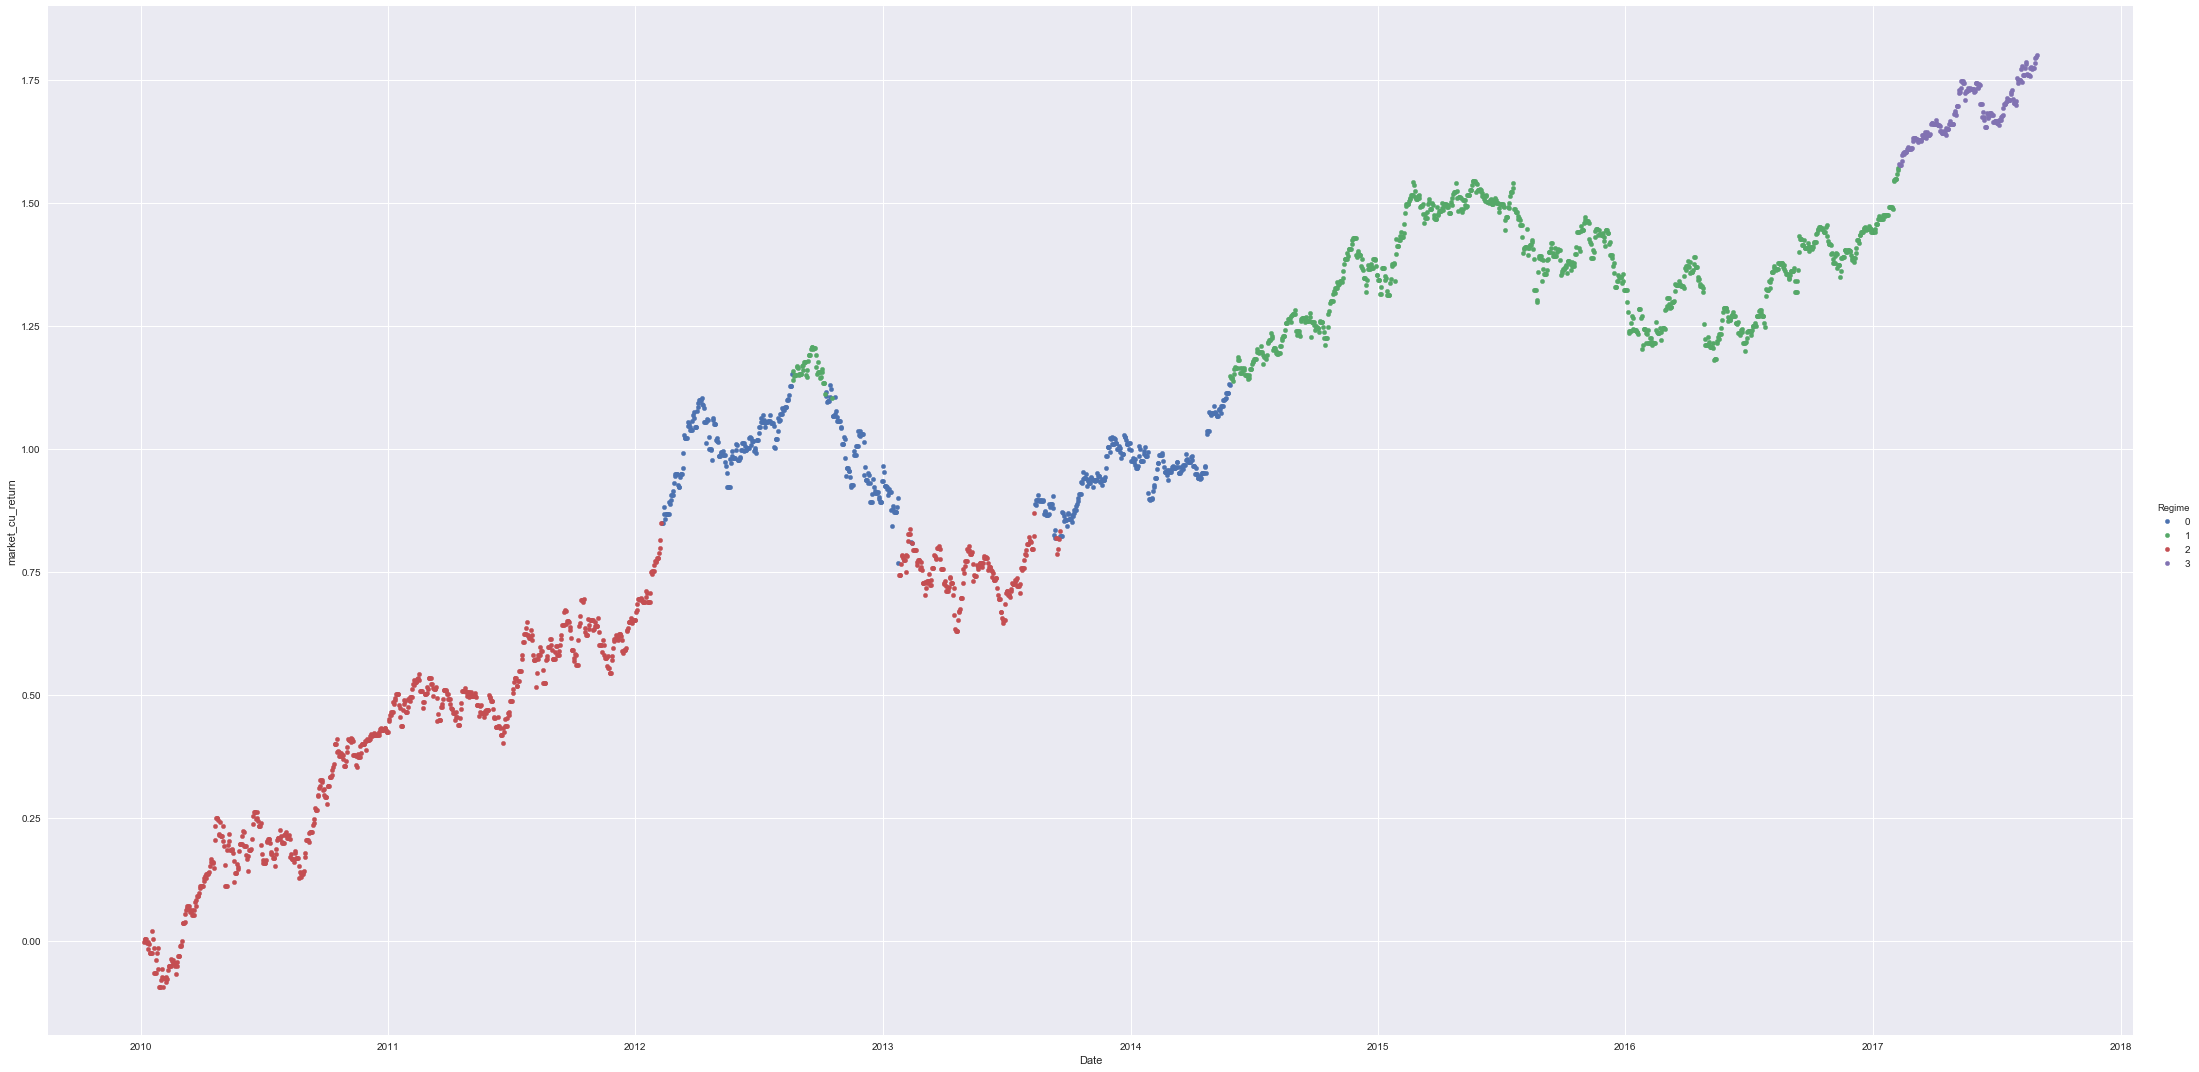

In [69]:
order = np.arange(0, regimes_number)
fig = sns.FacetGrid(data=regimes, hue='Regime', hue_order=order, aspect=2, size=15)
fig.map(plt.pyplot.scatter, 'Date', 'market_cu_return', s=20).add_legend()
plt.pyplot.show()

In [71]:
for i in order:
    print('Mean for regime {0}: {1}'.format(i, best_mix.means_[i][0]))
    print('Co-variance for regime {0}: {1}\n'.format(i, best_mix.covariances_[i]))

Mean for regime 0: 72.2510498942
Co-variance for regime 0: 26.0392622199

Mean for regime 1: 105.349929124
Co-variance for regime 1: 132.221860826

Mean for regime 2: 44.3657054411
Co-variance for regime 2: 102.042863593

Mean for regime 3: 146.134348616
Co-variance for regime 3: 60.130281676



Regime 0: Low mean and Low covariance.

Regime 1: High mean and High covariance.

Regime 2: Low mean and High covariance.

Regime 3: High mean and Low covariance.